# 对泡利字符串和的评估

## 概述

我们需要在各种量子算法中评估电路上许多泡利字符串项的总和，VQE 中哈密顿量 $H$ 的基态制备就是一个典型的例子。
我们需要计算哈密顿量$H$的期望值，即$\langle 0^N \vert U^{\dagger}(\theta) H U(\theta) \vert 0^N \rangle$并更新参数 $U(\theta)$
中的 $\theta$ 基于 VQE 工作流程中的梯度下降。在本教程中，我们将演示 ``TensorCircuit`` 支持的五种方法来计算 $\langle H \rangle$：
1. $\langle H \rangle = \sum_{i} \langle h_{i} \rangle$，其中 $h_{i}$ 是泡利串运算符；

2. 与 1 类似，但我们通过 ``vmap`` 计算泡利字符串的总和；

3. $\langle H \rangle$ 其中 $H$ 是一个稀疏矩阵；

4. $\langle H \rangle$ 其中$H$ 是一个稠密矩阵；

5. $H$ 的矩阵乘积算子 (MPO) 的期望值。

我们以横向场模型（TFIM）为例，其哈密顿量为
$
H = \sum_{i} \sigma_{i}^{x} \sigma_{i+1}^{x} - \sum_{i} \sigma_{i}^{z},
$
其中 $\sigma_{i}^{x,z}$ 是第 $i$ 个量子比特的泡利矩阵。

## 设置

In [1]:
import time
from functools import partial
import numpy as np
import tensorflow as tf
import tensornetwork as tn
import optax
import tensorcircuit as tc

K = tc.set_backend("tensorflow")

xx = tc.gates._xx_matrix  # 要使用的 xx 门矩阵

In [2]:
n = 10  # 量子比特数
nlayers = 4  # 电路层数

## 参数化量子电路

In [3]:
# 定义 ansatz 电路以评估哈密顿期望
def tfim_circuit(param):
    c = tc.Circuit(n)
    for j in range(nlayers):
        for i in range(n - 1):
            c.exp1(i, i + 1, unitary=xx, theta=param[2 * j, i])
        for i in range(n):
            c.rz(i, theta=param[2 * j + 1, i])
    return c

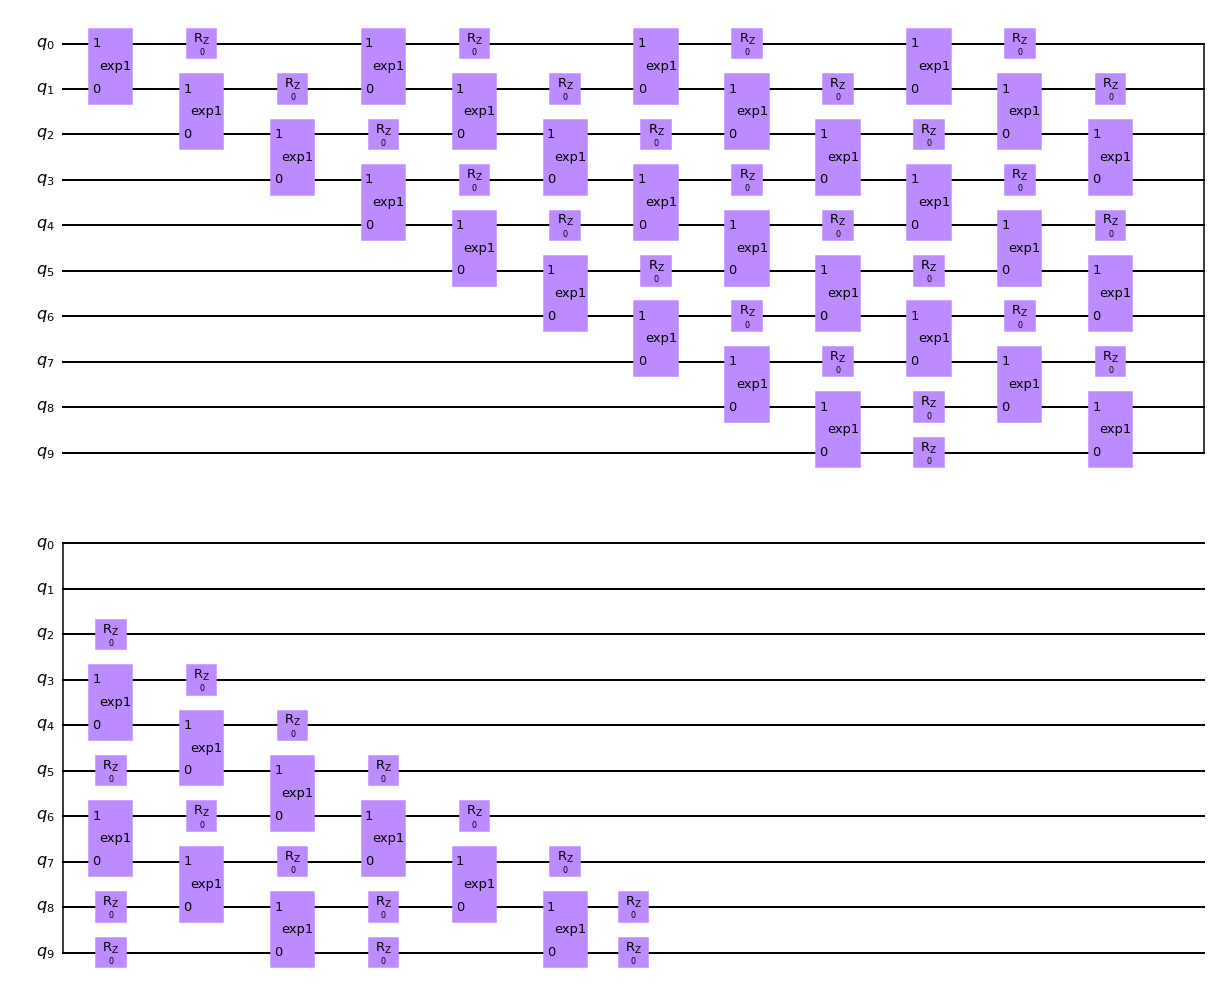

In [4]:
# 我们使用的电路 ansatz 如下图所示，双量子比特门是阶梯型布局
tfim_circuit(np.zeros([2 * nlayers, n])).draw(output="mpl")

## 主优化循环

VQE 训练循环（支持任意梯度函数形式）

In [5]:
# 我们为评估泡利字符串和的不同方法定义了通用 train_step 函数
def train_step(vf, maxiter=400):
    param = K.implicit_randn(shape=[2 * nlayers, n], stddev=0.01)
    if K.name == "tensorflow":
        opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))
    else:  # jax
        opt = K.optimizer(optax.adam(1e-2))
    vgf = tc.backend.jit(tc.backend.value_and_grad(vf))
    time0 = time.time()
    _ = vgf(param)
    time1 = time.time()
    print("staging time: ", time1 - time0)
    times = []
    for i in range(maxiter):
        time0 = time.time()
        e, grad = vgf(param)  # 能量和梯度
        time1 = time.time()
        times.append(time1 - time0)
        param = opt.update(grad, param)
        if i % 200 == 0:
            print(e)
    print("running time: ", np.mean(times))
    return e

##  1. 泡利串运算符和

In [6]:
# 以简单的方式对泡利字符串期望求和
def tfim_energy(c, j=1.0, h=-1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += h * c.expectation_ps(z=[i])  # <Z_i>
    for i in range(n - 1):  # OBC
        e += j * c.expectation_ps(x=[i, i + 1])  # <X_iX_{i+1}>
    return K.real(e)

In [7]:
def vqe_tfim_v1(param):
    c = tfim_circuit(param)
    e = tfim_energy(c)
    return e

In [8]:
train_step(vqe_tfim_v1)

staging time:  32.8380286693573
tf.Tensor(-9.988716, shape=(), dtype=float32)
tf.Tensor(-11.872444, shape=(), dtype=float32)
running time:  0.004370659589767456


<tf.Tensor: shape=(), dtype=float32, numpy=-11.833584>

## 2. Vmap 泡利字符串运算符和

作用于 $n$ 个量子比特的泡利算子串可以表示为长度为 $n$ 的向量 $v\in\{0,1,2,3\}^n$，其中 $v_i = j$ 的值对应到$\sigma_i^j$，
即泡利算子 $\sigma^j$ 作用于量子比特 $i$
($\sigma^0 = I, \sigma^1 = X, \sigma^2 = Y, \sigma^ 3 = Z$)。
例如，在这种表示法中，如果 $n=3$，则项 $X_1 X_2$ 对应于 $v = [0,1,1]$。 我们将泡利串的这种向量表示称为``结构``，一个结构列表，
一个对应于哈密顿量中的每个泡利串项，被用作计算多个期望值总和的输入的方法。
如果每个结构都有一个相关的权重，例如,项 $X_i X_{i+1}$ 在 TFIM 哈密顿量中具有权重 $J_i$，然后我们定义相应的权重张量。

In [9]:
def measurement(s, structure):
    c = tc.Circuit(n, inputs=s)
    return tc.templates.measurements.parameterized_measurements(
        c, structure, onehot=True
    )


measurement = K.jit(K.vmap(measurement, vectorized_argnums=1))

structures = []
for i in range(n - 1):
    s = [0 for _ in range(n)]
    s[i] = 1
    s[i + 1] = 1
    structures.append(s)
for i in range(n):
    s = [0 for _ in range(n)]
    s[i] = 3
    structures.append(s)

structures = tc.array_to_tensor(structures)
weights = tc.array_to_tensor(
    np.array([1.0 for _ in range(n - 1)] + [-1.0 for _ in range(n)])
)

print(K.numpy(structures))
print(K.numpy(weights))


def vqe_tfim_v2(param):
    c = tfim_circuit(param)
    s = c.state()
    ms = measurement(s, structures)
    return K.sum(ms * K.real(weights))

[[1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j]
 [3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 

In [10]:
train_step(vqe_tfim_v2)

staging time:  18.593740940093994
tf.Tensor(-9.989147, shape=(), dtype=float32)
tf.Tensor(-11.868203, shape=(), dtype=float32)
running time:  0.009751033186912537


<tf.Tensor: shape=(), dtype=float32, numpy=-11.852951>

## 3. 稀疏矩阵

如果哈密顿量是稀疏的，则可以在空间和时间方面获得显着的计算优势，在这种情况下，算子的稀疏表示是可取的。
这可以通过在两阶段过程中从泡利结构列表转换来以后端无关的方式实现。
首先，我们将其转换为 COO (COOrdinate) 格式的稀疏 numpy 矩阵，然后在给定的 ML 后端将其转换为 coo 稀疏张量。

In [11]:
def vqe_tfim_template(param, op):
    c = tfim_circuit(param)
    e = tc.templates.measurements.operator_expectation(
        c, op
    )  # 在 operator_expectation 中，“hamiltonian”可以是稀疏矩阵、稠密矩阵或 mpo
    return e

In [12]:
# 首先，我们生成如下哈密顿矩阵

hamiltonian_sparse_numpy = tc.quantum.PauliStringSum2COO_numpy(structures, weights)
hamiltonian_sparse_numpy

<1024x1024 sparse matrix of type '<class 'numpy.complex64'>'
	with 9988 stored elements in COOrdinate format>

In [13]:
hamiltonian_sparse = K.coo_sparse_matrix(
    np.transpose(
        np.stack([hamiltonian_sparse_numpy.row, hamiltonian_sparse_numpy.col])
    ),
    hamiltonian_sparse_numpy.data,
    shape=(2**n, 2**n),
)

In [14]:
vqe_tfim_v3 = partial(vqe_tfim_template, op=hamiltonian_sparse)

In [15]:
train_step(vqe_tfim_v3)

staging time:  15.030275106430054
tf.Tensor(-9.994525, shape=(), dtype=float32)
tf.Tensor(-11.880127, shape=(), dtype=float32)
running time:  0.0027445638179779052


<tf.Tensor: shape=(), dtype=float32, numpy=-11.842913>

## 4. 密集矩阵

In [16]:
hamiltonian_dense = K.to_dense(hamiltonian_sparse)

In [17]:
vqe_tfim_v4 = partial(vqe_tfim_template, op=hamiltonian_dense)

In [18]:
train_step(vqe_tfim_v4)

staging time:  15.457977056503296
tf.Tensor(-9.975462, shape=(), dtype=float32)
tf.Tensor(-11.872018, shape=(), dtype=float32)
running time:  0.0038266772031784056


<tf.Tensor: shape=(), dtype=float32, numpy=-11.851571>

## 5. MPO

TFIM 哈密顿量，作为短程自旋哈密顿量，具有有效的矩阵乘积算子表示。这是一个使用 TensorCircuit 的两阶段过程。
我们首先通过 TensorNetwork 或 Quimb 包将哈密顿量转换为 MPO 表示。

In [34]:
# 通过转换 tensornetwork 包中的 MPO 生成对应的 MPO
Jx = np.array([1.0 for _ in range(n - 1)])  # xx 相互作用的力量 (OBC)
Bz = np.array([1.0 for _ in range(n)])  # 横向场强
# 注意 Bz 符号的规定
hamiltonian_mpo = tn.matrixproductstates.mpo.FiniteTFI(
    Jx, Bz, dtype=np.complex64
)  # TensorNetwork 中的矩阵乘积算子
hamiltonian_mpo = tc.quantum.tn2qop(hamiltonian_mpo)  # TensorCircuit 中的 QuOperator

In [32]:
vqe_tfim_v5 = partial(vqe_tfim_template, op=hamiltonian_mpo)

In [33]:
train_step(vqe_tfim_v5)

staging time:  28.10707402229309
tf.Tensor(-9.985009, shape=(), dtype=float32)
tf.Tensor(-11.901758, shape=(), dtype=float32)
running time:  0.004696276783943176


<tf.Tensor: shape=(), dtype=float32, numpy=-11.862544>